<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU avec une couche de convolution 1D pour réaliser des prédictions sur notre série temporelle.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

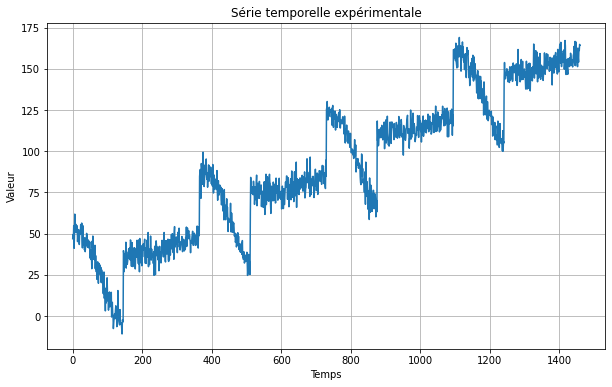

In [ ]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

# Préparation des données X et Y

In [ ]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

**1. Séparation des données en données pour l'entrainement et la validation**

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

In [ ]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Préparation des données X et des labels Y**

On commence par créer notre dataset à partir de la série (remarque : les valeurs ci-dessous sont en réalité mélangées) :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY_2.png?raw=true" width="1200"> 

In [ ]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

**3. Normalisation des données**

In [ ]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie)
std = tf.math.reduce_std(serie)

# Normalise les données
Serie_Normalisee = (serie-mean)/std
min = tf.math.reduce_min(serie)
max = tf.math.reduce_max(serie)

In [ ]:
# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

# Création du modèle CNN + GRU

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Le réseau que nous allons mettre en place est un réseau de neurones récurrent, composé de :
  - Une couche de convolution 1D
  - Une couche récurrente GRU à 40 neurones, de type séquence vers vecteur (sequence to vector) (Encodeur)
  - Une couche dense avec 40 neurones et fonction d'activation tanh (Décodeur)
  - Une couche dense avec 1 neurone (Générateur)

Pour adapter les données en entrée et en sortie du réseau au format attendu, nous allons utiliser une [couche de type lambda](https://keras.io/api/layers/core_layers/lambda/) avec Keras. Ce type de couche nous permet d'intégrer une fonction spécifique en tant que couche dans notre réseau de neurone.

- En entrée de la première couche récurrente, le format attendu est de type : [batch_size, #instants, #dims].   
Le **format d'entrée attendu est donc [None,None,1]** car notre série temporelle est de type univariée, qu'on souhaite pouvoir traiter une séquence infinie, et que le batch size est géré automatiquement par tensorflow.  
Il faut donc en entrée transformer le format [taille_fenetre, 1] vers le format [None, None, 1].  

- En sortie de la deuxième couche récurrente, le format est de type [batch_size, #instants, #neurones]. Il sera de type [None, None, 40].  
- La couche dense possède un seul neurone. En **sortie de la couche dense, le format est de type [None, None, 1]**.

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/GRU_CNN.png?raw=true" width="1200"> 

Pour insérer une dimension de type `None` au format de l'entrée, on utilise la méthode [expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims) de tensorflow. 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

In [ ]:
# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
e_cnn = tf.keras.layers.Conv1D(filters=32,kernel_size=3, strides=1, padding="causal", activation="relu")(e_adapt)
e_cnn = tf.keras.layers.Dropout(0.05)(e_cnn)
s_encodeur = tf.keras.layers.GRU(40)(e_cnn)

# Décodeur
s_decodeur = tf.keras.layers.Dense(40,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 20, 1)        0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 20, 32)       128         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 20, 32)       0           conv1d[0][0]                     
______________________________________________________________________________________________

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()
model.load_weights("model_initial.hdf5")

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
#optimiseur=tf.keras.optimizers.Adam()
optimiseur=tf.keras.optimizers.SGD()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
30/30 [==============================] - 2s 11ms/step - loss: 0.2385 - mae: 0.5937

Epoch 00001: loss improved from inf to 0.24993, saving model to poids.hdf5
Epoch 2/100
30/30 [==============================] - 0s 9ms/step - loss: 0.2537 - mae: 0.6091

Epoch 00002: loss improved from 0.24993 to 0.24895, saving model to poids.hdf5
Epoch 3/100
30/30 [==============================] - 0s 9ms/step - loss: 0.2470 - mae: 0.5947

Epoch 00003: loss did not improve from 0.24895
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2351 - mae: 0.5820

Epoch 00004: loss improved from 0.24895 to 0.24851, saving model to poids.hdf5
Epoch 5/100
30/30 [==============================] - 0s 9ms/step - loss: 0.2548 - mae: 0.6151

Epoch 00005: loss improved from 0.24851 to 0.24700, saving model to poids.hdf5
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 0.2452 - mae: 0.5973

Epoch 00006: loss improved from 0.24700 to 0.24417, saving model to p

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

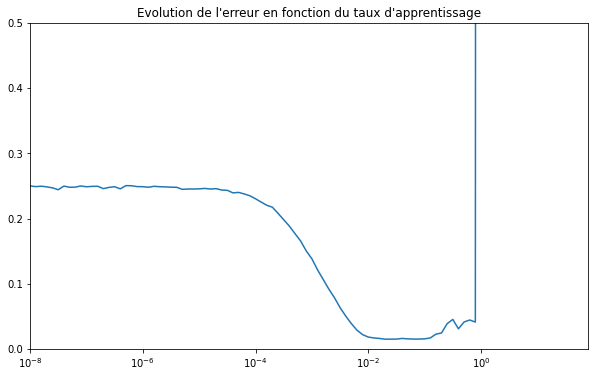

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 0.5])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.n_steps = 0
        self.t_step = 0
        self.n_batch = 0
        self.total_batch = 0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.t_step = self.t_step  + timer()-self.starttime
        self.n_steps = self.n_steps + 1
        if (self.total_batch == 0):
          self.total_batch=self.n_batch - 1
    def on_train_batch_begin(self,batch,logs=None):
      self.n_batch= self.n_batch + 1
    def GetInfos(self):
      return([self.t_step/(self.n_steps*self.total_batch), self.t_step, self.total_batch])

cb = TimingCallback()

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.09,
    decay_steps=10,
    decay_rate=0.05)

# Définition de l'optimiseur à utiliser
#optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_entrainement.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

# Affiche quelques informations sur les timings
infos = cb.GetInfos()
print("Step time : %.3f" %infos[0])
print("Total time : %.3f" %infos[1])

Epoch 1/500
30/30 [==============================] - 3s 43ms/step - loss: 0.0148 - mae: 0.1313 - val_loss: 0.0491 - val_mae: 0.2639

Epoch 00001: loss improved from inf to 0.01726, saving model to poids_entrainement.hdf5
Epoch 2/500
30/30 [==============================] - 0s 13ms/step - loss: 0.0198 - mae: 0.1466 - val_loss: 0.0271 - val_mae: 0.1855

Epoch 00002: loss did not improve from 0.01726
Epoch 3/500
30/30 [==============================] - 0s 14ms/step - loss: 0.0232 - mae: 0.1608 - val_loss: 0.0164 - val_mae: 0.1389

Epoch 00003: loss did not improve from 0.01726
Epoch 4/500
30/30 [==============================] - 1s 14ms/step - loss: 0.0146 - mae: 0.1268 - val_loss: 0.0137 - val_mae: 0.1202

Epoch 00004: loss improved from 0.01726 to 0.01488, saving model to poids_entrainement.hdf5
Epoch 5/500
30/30 [==============================] - 0s 14ms/step - loss: 0.0146 - mae: 0.1191 - val_loss: 0.0165 - val_mae: 0.1357

Epoch 00005: loss improved from 0.01488 to 0.01468, saving mo

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

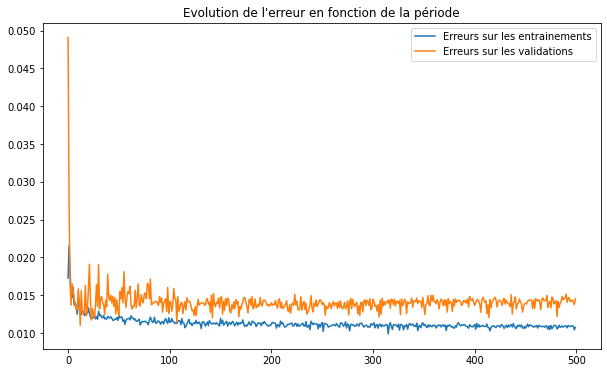

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

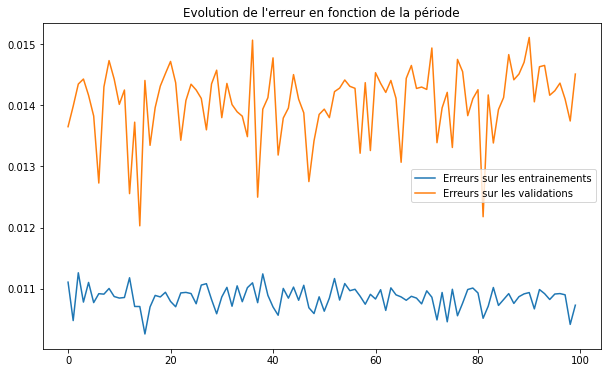

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

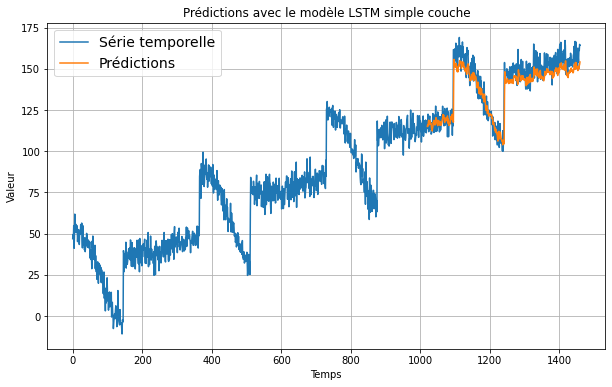

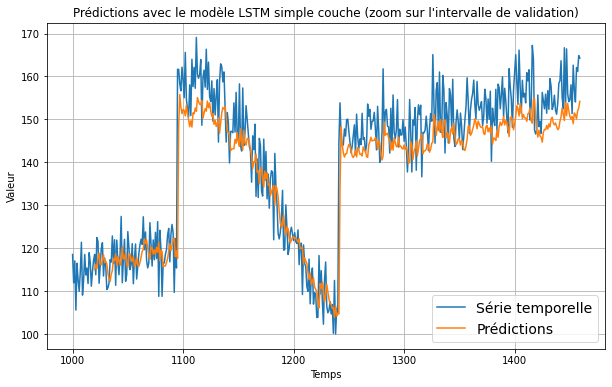

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle LSTM simple couche')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle LSTM simple couche (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()

print(mae)
print(mse)

5.681990501798439
54.64169905807332
